In [1]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy.stats as stats
import csv

from statsmodels.stats.multicomp import MultiComparison

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
con = pymysql.connect(host="localhost", user="gabic", passwd="1234", db="doenca_renal_cronica")
con.select_db('doenca_renal_cronica')
cursor = con.cursor()  
cursor.connection.autocommit(True)

In [3]:
#criando os dataframes por tabela 
dados_consulta = pd.read_sql('SELECT * FROM doenca_renal_cronica.dados_consulta',con=con)
cidade = pd.read_sql('SELECT * FROM doenca_renal_cronica.cidade',con=con)
ubs = pd.read_sql('SELECT * FROM doenca_renal_cronica.ubs',con=con)
aval_funcao_renal = pd.read_sql('SELECT * FROM doenca_renal_cronica.aval_funcao_renal',con=con)
consulta_has = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_has',con=con)
consulta_drc = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_drc',con=con)
consulta_dm = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_dm',con=con)
calculo_tfg = pd.read_sql('SELECT * FROM doenca_renal_cronica.calculo_tfg',con=con)
preparacao_trs = pd.read_sql('SELECT * FROM doenca_renal_cronica.preparacao_trs',con=con)
raca = pd.read_sql('SELECT * FROM doenca_renal_cronica.raca',con=con)
instrucao = pd.read_sql('SELECT * FROM doenca_renal_cronica.instrucao',con=con)
paciente = pd.read_sql('SELECT * FROM doenca_renal_cronica.paciente',con=con)
exame_fisico = pd.read_sql('SELECT * FROM doenca_renal_cronica.exame_fisico',con=con)
avaliacao_tratamento = pd.read_sql('SELECT * FROM doenca_renal_cronica.avaliacao_tratamento',con=con)
medicamento = pd.read_sql('SELECT * FROM doenca_renal_cronica.medicamento',con=con)
complicacao_funcao_renal = pd.read_sql('SELECT * FROM doenca_renal_cronica.complicacao_funcao_renal',con=con)

#dicionario com todas tabelas
dic = {'dados_consulta':dados_consulta,'cidade':cidade,'ubs':ubs,'aval_funcao_renal':aval_funcao_renal,
       'consulta_has':consulta_has,'consulta_drc':consulta_drc,'consulta_dm':consulta_dm,'calculo_tfg':calculo_tfg,
       'preparacao_trs':preparacao_trs,'raca':raca,'instrucao':instrucao,'paciente':paciente,'exame_fisico':exame_fisico,
       'avaliacao_tratamento':avaliacao_tratamento,'medicamento':medicamento,'complicacao_funcao_renal':complicacao_funcao_renal
      }

In [4]:
#separando apenas as colunas com números

df_num_dados_consulta = dados_consulta.select_dtypes(include = ['float64', 'int64'])
df_num_cidade = cidade.select_dtypes(include = ['float64', 'int64'])
df_num_ubs = ubs.select_dtypes(include = ['float64', 'int64'])
df_num_aval_funcao_renal = aval_funcao_renal.select_dtypes(include = ['float64', 'int64'])
df_num_consulta_has = consulta_has.select_dtypes(include = ['float64', 'int64'])
df_num_consulta_drc = consulta_drc.select_dtypes(include = ['float64', 'int64'])
df_num_consulta_dm = consulta_dm.select_dtypes(include = ['float64', 'int64'])
df_num_calculo_tfg = calculo_tfg.select_dtypes(include = ['float64', 'int64'])
df_num_preparacao_trs = preparacao_trs.select_dtypes(include = ['float64', 'int64'])
df_num_raca = raca.select_dtypes(include = ['float64', 'int64'])
df_num_instrucao = instrucao.select_dtypes(include = ['float64', 'int64'])
df_num_paciente = paciente.select_dtypes(include = ['float64', 'int64'])
df_num_exame_fisico = exame_fisico.select_dtypes(include = ['float64', 'int64'])
df_num_avaliacao_tratamento = avaliacao_tratamento.select_dtypes(include = ['float64', 'int64'])
df_num_medicamento = medicamento.select_dtypes(include = ['float64', 'int64'])
df_num_complicacao_funcao_renal = complicacao_funcao_renal.select_dtypes(include = ['float64', 'int64'])

dic_num = {'dados_consulta':df_num_dados_consulta,'cidade':df_num_cidade,'ubs':df_num_ubs,'afr':df_num_aval_funcao_renal,
       'has':df_num_consulta_has,'drc':df_num_consulta_drc,'dm':df_num_consulta_dm,'calculo_tfg':df_num_calculo_tfg,
       'preparacao_trs':df_num_preparacao_trs,'raca':df_num_raca,'instrucao':df_num_instrucao,'paciente':df_num_paciente,'exame_fisico':df_num_exame_fisico,
       'aval_tratamento':df_num_avaliacao_tratamento,'medicamento':df_num_medicamento,'cfr':df_num_complicacao_funcao_renal
      }

for tabela in dic_num:
    for coluna in dic_num[tabela].keys():
        i_split = coluna.split('_')
        if i_split[0]=='id':
            dic_num[tabela]=dic_num[tabela].drop(columns=[coluna], errors='ignore')
        if i_split[0]=='dt':
            dic_num[tabela]=dic_num[tabela].drop(columns=[coluna], errors='ignore')
        if i_split[0]=='total':
            dic_num[tabela]=dic_num[tabela].drop(columns=[coluna], errors='ignore')

In [13]:
dic_num

{'dados_consulta':       tempoAcomp  estagioI_alb  estagioF_alb
 0              5             0             0
 1             48             1             0
 2              1             0             0
 3              0             0             0
 4              6             0             0
 5              0             0             0
 6              0             0             0
 7             40             1             1
 8             51             0             2
 9              0             0             0
 10            14             1             1
 11            38             0             0
 12             0             0             0
 13            48             2             2
 14             4             0             0
 15             2             0             0
 16            32             0             0
 17            48             0             0
 18             2             0             0
 19            45             0             0
 20            4

In [5]:
#separando em uma matriz as todas colunas sem 0
triglicerides_inicial_snulo = dic_num['cfr']['triglicerides_inicial']
triglicerides_inicial_snulo = triglicerides_inicial_snulo [triglicerides_inicial_snulo.values != 0.0]
dic_snulo ={}
for tabela in dic_num:
    for coluna in dic_num[tabela]:
        copia = dic_num[tabela][coluna]
        copia= copia[copia.values != 0.0]
#             dic_snulo[tabela]=dic_num[tabela].drop(columns=['id_'+tabela])
        dic_snulo[coluna] = copia

In [6]:
type(dic_snulo)

dict

In [7]:
df_dic_snulo = pd.DataFrame(data=dic_snulo)

In [8]:
results = ols('albumina_inicial ~ albumina_final', 
               data=df_dic_snulo).fit()

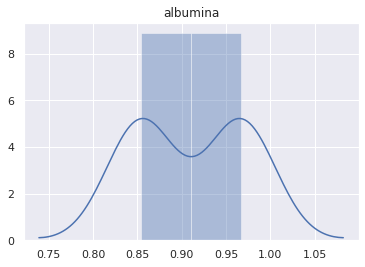

In [9]:
sns.set(color_codes=True)

inicial = stats.shapiro(results.resid)
plt.title('albumina')
sns.distplot(inicial)
plt.show()

In [1]:
# stats.ttest_rel(dic_snulo['albumina_inicial'], dic_snulo['albumina_final'])

In [15]:
stats.ttest_rel(dic_num['afr']['albumina_inicial'], dic_num['afr']['albumina_final'])

Ttest_relResult(statistic=12.928979552575477, pvalue=8.054156000537069e-38)